# Brain Tumor Classifier

## Import modules

In [1]:
from model.model_v1 import *
from utils.dataset_loader import *
from utils.loss_tracker import *
from utils.plot_utils import *

from torchvision.transforms import v2
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import os

## Setup

In [2]:
# Dataset dir path.
DATASET_DIR = "./data"

# Log dir path.
#LOG_DIR = "./lightning_logs/version_12/checkpoints/"

In [3]:
# Define input the image size (network input).
IMAGE_SIZE = 224

# Define train set and test set transformations.
train_transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),                    
    v2.RandomHorizontalFlip(p=0.1),                           
    v2.RandomRotation(degrees=1),                             
    #v2.RandomAffine(degrees=0, scale=(0.9, 1.1)),              
    #v2.ToDtype(torch.float32, scale=True),                    
    #v2.Normalize(mean=[0.485, 0.456, 0.406],                  
    #             std=[0.229, 0.224, 0.225]),
    v2.ToTensor(), 
    v2.ToDtype(torch.float32, scale=True)
])

test_transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),                    
    v2.ToTensor(), 
    v2.ToDtype(torch.float32, scale=True)
])

# Define the datamodule.
brisc_dm = BRISCDataModule(
    data_dir=DATASET_DIR,
    batch_size=128,
    train_transform=train_transform,
    test_transform=test_transform,
    num_workers=9
)

/usr/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Plot dataset information

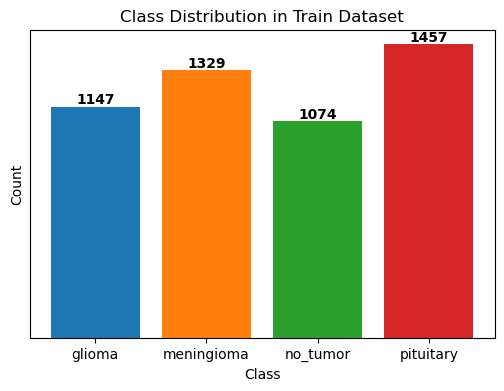

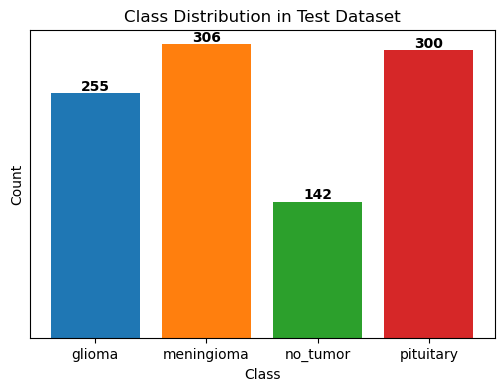

In [4]:
plot_distribution(DATASET_DIR, "Train")
plot_distribution(DATASET_DIR, "Test")

## Define the model

In [5]:
model = ResNetFineTuner(num_classes=4, lr=1e-4, freeze_backbone=True)

/usr/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
/usr/lib/python3

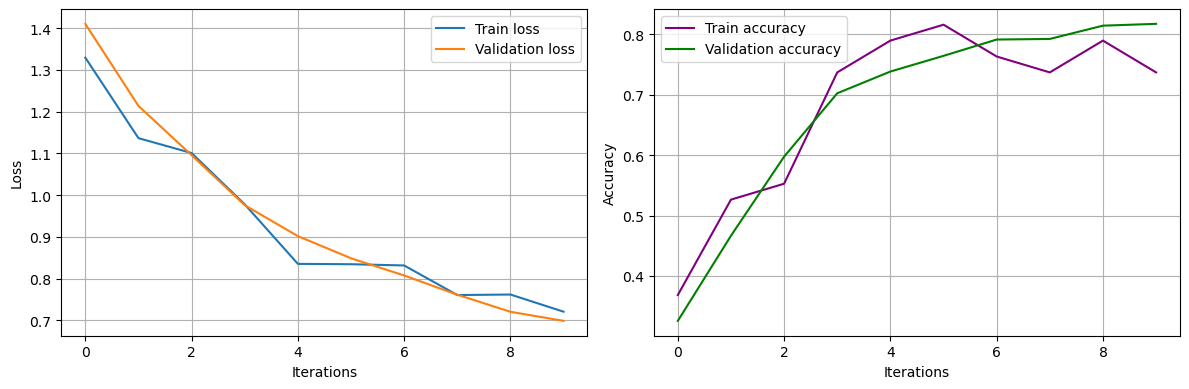

In [6]:
# Define the loss tracker callback.
loss_tracker = LossTracker()

# Define the early stopping callback.
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

# Define the checkpoint callback.
# (Used to save the model with the lowest
# validation loss).
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    verbose=True
)

# Define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    callbacks=[loss_tracker, early_stopping, checkpoint_callback],
    enable_progress_bar=False
)

# Train model.
trainer.fit(model, brisc_dm)
# Plot losses.
loss_tracker.plot()

## Fine tuning the model

In [7]:
#ckpt_path = [f for f in os.listdir(LOG_DIR)][0]
#ckpt_path = os.path.join(LOG_DIR, ckpt_path)
#print(ckpt_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/luca/Documents/git/Brain_Tumor_Classifier/lightning_logs/version_19/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
Epoch 0, global step 32: 'val_loss' reached 0.14628 (best 0.14628), saving model to '/home/luca/Documents/git/Brain_Tumor_Classifier/lightning_logs/version_19/checkpoi

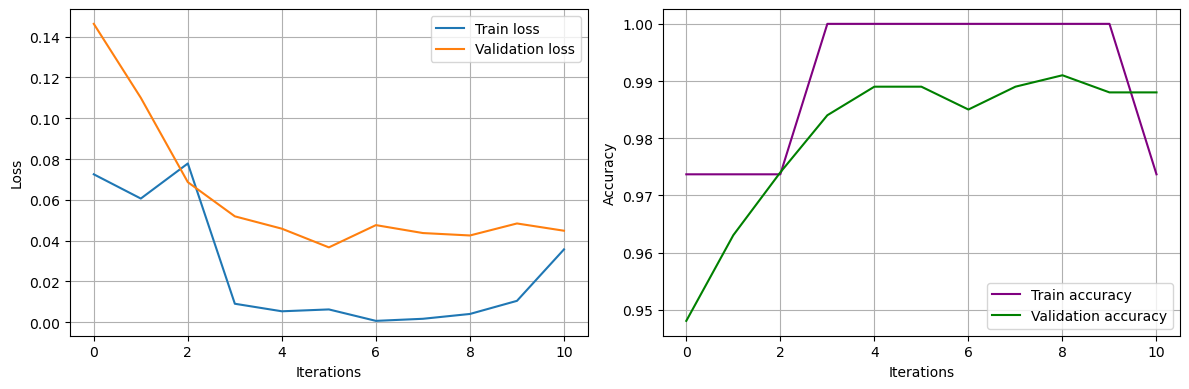

In [8]:
# Load best model.
model = ResNetFineTuner.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

# Unfreeze backbone.
for param in model.parameters():
    param.requires_grad = True

# Reset plots.
loss_tracker.train_loss = []
loss_tracker.train_acc = []
loss_tracker.val_loss = []
loss_tracker.val_acc = []

# Re-define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=15,
    callbacks=[loss_tracker, early_stopping, checkpoint_callback],
    enable_progress_bar=False
)

# Re-start training.
trainer.fit(model, brisc_dm)
# Plot losses.
loss_tracker.plot()

In [9]:
# Load the best model (after fine tuning).
model = ResNetFineTuner.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

# Test model.
trainer.test(model, brisc_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9850448369979858     │
│         test_loss         │   0.049915727227926254    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.049915727227926254, 'test_acc': 0.9850448369979858}]